Input File(s)

In [17]:
img1Path = "./pipelineInput/0X7A85BE2A483D2B3F_82.png"
img2Path = "./pipelineInput/0X7A85BE2A483D2B3F_98.png"

Center Model

In [18]:
import cv2
import numpy as np
import torch

#prepare input
def loadImage(imgPath):
    image = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE)  # ensure 1-channel
    if image is None:
        raise FileNotFoundError(f"Image not found: {imgPath}")

    image = image.astype('float32') / 255.0  # normalize manually if not using transforms
    image = np.expand_dims(image, axis=0)    # [1, 112, 112]
    image = np.expand_dims(image, axis=0)    # [1, 1, 112, 112], simulated dataloader
    image = torch.tensor(image, dtype=torch.float32)

    return image

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionNet(nn.Module):
    def __init__(self, image_size=112, patch_size=16, embed_dim=64, num_heads=4, depth=2):
        super().__init__()
        assert image_size % patch_size == 0, "Image size must be divisible by patch size"

        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        self.embed_dim = embed_dim

        self.patch_embed = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)

        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.head = nn.Sequential(
        nn.LayerNorm(embed_dim),
        nn.Linear(embed_dim, 2),
        )

    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)
        x = x + self.pos_embed

        x = self.transformer(x)
        x = x.mean(dim=1)

        out = self.head(x)
        return out

In [20]:
import torch
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionNet().to(device)

weightsPath = "./center_model.pth"
model.load_state_dict(torch.load(weightsPath, map_location=device))

img1 = loadImage(img1Path)
img2 = loadImage(img2Path)

with torch.no_grad():
    coord1 = model(img1.to(device))
    coord2 = model(img2.to(device))


MedSam

In [21]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from transformers import SamModel, SamProcessor
from torch import nn
import torch.optim as optim
from tqdm import tqdm

In [22]:
def load_checkpoint(model, optimizer, filepath, device):
    checkpoint = torch.load(filepath, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from {filepath}, epoch {epoch}, loss {loss:.4f}")
    return epoch, loss


In [23]:
model = SamModel.from_pretrained("wanglab/medsam-vit-base").to(device)
processor = SamProcessor.from_pretrained("wanglab/medsam-vit-base")
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)


load_checkpoint(model, optimizer, "./sam_ultrasound_checkpoints/best_model.pt", device)


Checkpoint loaded from ./sam_ultrasound_checkpoints/best_model.pt, epoch 5, loss 0.0256


(5, 0.02558339418563992)

In [24]:
# prep images and coordinates for medsam
def prepDataMEDSAM(imgPath, coords):
    image_size = 256
    image_transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor()
        ])
    
    img = Image.open(imgPath).convert("RGB")
    orig_w, orig_h = img.size
    img_tensor = image_transform(img)

    scaled_x = int(coords[0] * image_size)
    scaled_y = int(coords[1] * image_size)
    coords = [[scaled_x, scaled_y]]

    return img_tensor, coords

img1Tensor, coords1 = prepDataMEDSAM(img1Path, coord1.numpy().squeeze())
img2Tensor, coords2 = prepDataMEDSAM(img2Path, coord2.numpy().squeeze())


In [25]:
inputs = processor(
                images=[img1Tensor, img2Tensor],
                input_points=[coords1, coords2],
                return_tensors="pt",
                do_rescale=False,
                padding="longest"
            ).to(device)
            
with torch.no_grad():
    outputs = model(**inputs)

pred_masks = outputs.pred_masks.cpu()

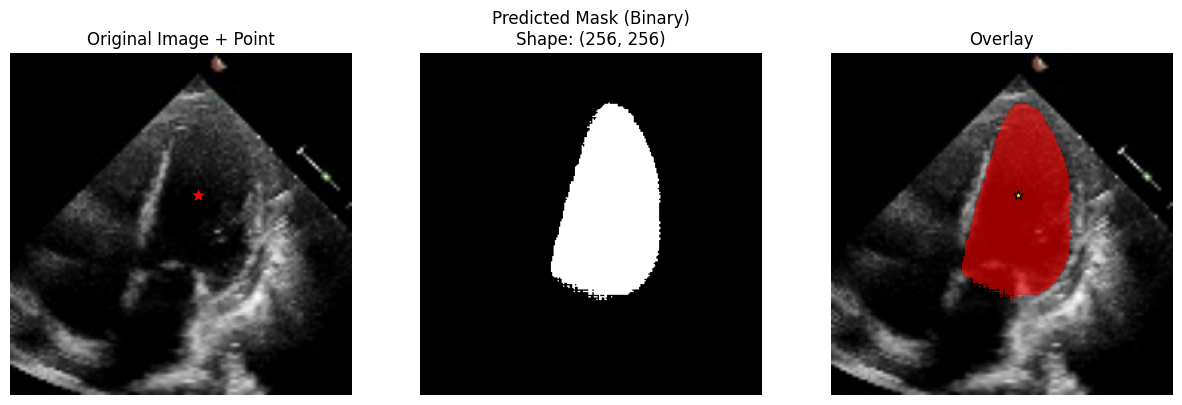

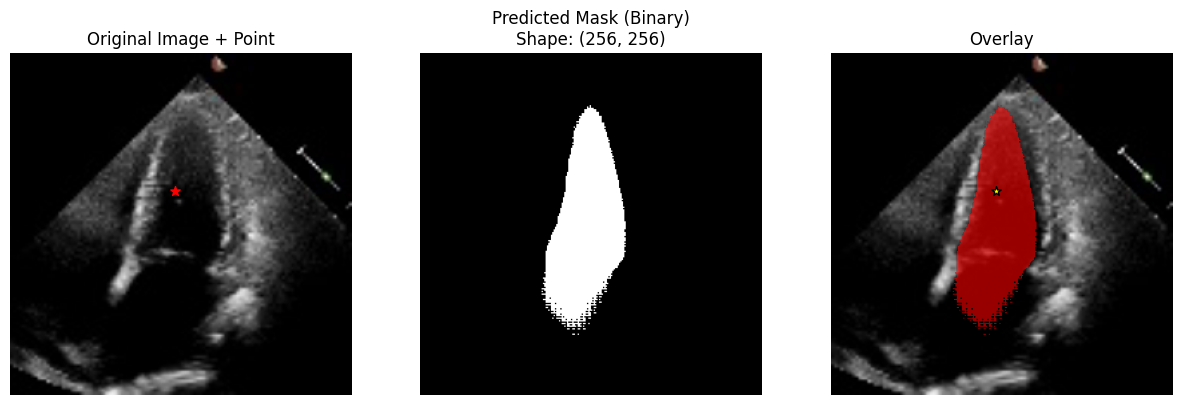

In [26]:
#visualize prediction
def visualizePreds(imgTensor, pred_mask, coords):
    image = imgTensor.permute(1, 2, 0).numpy()

    medsam_seg_prob = torch.sigmoid(pred_mask).numpy()
    
    if len(medsam_seg_prob.shape) == 3:
        mask_2d = medsam_seg_prob[0]
    else:
        mask_2d = medsam_seg_prob
    
    binary_mask = (mask_2d > 0.5).astype(np.float32)

    
    plt.figure(figsize=(15, 5))

    # input image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.scatter(coords[0][0], coords[0][1], c='red', s=50, marker='*')
    plt.title("Original Image + Point")
    plt.axis('off')

    # predicted mask
    plt.subplot(1, 3, 2)
    plt.imshow(binary_mask, cmap="gray")
    plt.title(f"Predicted Mask (Binary)\nShape: {binary_mask.shape}")
    plt.axis('off')
    
    # overlay
    plt.subplot(1, 3, 3)
    plt.imshow(image)
    colored_mask = np.zeros((*binary_mask.shape, 4))  # RGBA
    colored_mask[binary_mask > 0.5] = [1, 0, 0, 0.6]  # Red with alpha
    plt.imshow(colored_mask)
    plt.scatter(coords[0][0], coords[0][1], c='yellow', s=50, marker='*', edgecolors='black')
    plt.title("Overlay")
    plt.axis('off')
    plt.show()

visualizePreds(img1Tensor, pred_masks[0].squeeze(), coords1)
visualizePreds(img2Tensor, pred_masks[1].squeeze(), coords2)

Calculate ejection fraction

In [27]:
#prep data
def prepMask(predMask):
    medsam_seg_prob = torch.sigmoid(predMask).numpy()

    if len(medsam_seg_prob.shape) == 3:
        mask_2d = medsam_seg_prob[0]
    else:
        mask_2d = medsam_seg_prob

    binaryMask = (mask_2d > 0.5).astype(np.uint8) * 255

    return binaryMask

mask1 = prepMask(pred_masks[0].squeeze())
mask2 = prepMask(pred_masks[1].squeeze())

In [28]:
from math import atan2, cos, sin, sqrt, pi, radians, degrees
def getOrientation(pts, img, draw=False):
    """Get the center and angle of a contour (main axis relative to the x-axis)

    Args:
        pts (_type_): points of the contour
        img (_type_): base image
        draw (bool, optional): Draw axes and center on the image. Defaults to False.

    Returns:
        cntr (tuple): center of the contour
        angle (tuple): angle of the contour
    """

    #https://docs.opencv.org/3.4/d1/dee/tutorial_introduction_to_pca.html
    sz = len(pts)
    data_pts = np.empty((sz, 2), dtype=np.float64)
    for i in range(data_pts.shape[0]):
        data_pts[i,0] = pts[i,0,0]
        data_pts[i,1] = pts[i,0,1]
    # Perform PCA analysis
    mean = np.empty((0))
    mean, eigenvectors, eigenvalues = cv2.PCACompute2(data_pts, mean)
    # Store the center of the object
    cntr = (int(mean[0,0]), int(mean[0,1]))
    
    
    p1 = (cntr[0] + eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + eigenvectors[0,1] * eigenvalues[0,0])
    p2 = (cntr[0] - eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - eigenvectors[1,1] * eigenvalues[1,0])
    if(draw):
        cv2.circle(img, cntr, 3, (255, 0, 255), 0)
        cv2.line(img, cntr, tuple(map(round, p2)), (0, 255, 0), 1)
        cv2.line(img, cntr, tuple(map(round, p1)), (255, 0, 0), 1)
    angle = degrees(atan2(eigenvectors[0,1], eigenvectors[0,0])) # orientation in degrees
    
    return cntr, angle


def rotateImage(img, angle, point):
#https://stackoverflow.com/questions/9041681/opencv-python-rotate-image-by-x-degrees-around-specific-point
    # angle-90 do orient the shape vertically
    rot_mat = cv2.getRotationMatrix2D(point, angle-90, 1.0)
    res = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    return res

def getContour(img):
    #expects there to be only one shape/contour
    # thresh = 127
    # im_bw = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), thresh, 255, cv2.THRESH_BINARY)[1]
    c, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return c[0]

def calculate_ejection_fraction(mask1, mask2):
    """
    Calculate the cardiac parameters, using the systolic and diastolic mask as an input. The mask featuring the smaller volume is assumend as the "End of systole" mask.


    Args:
        mask1 (_type_): _description_
        mask2 (_type_): _description_

    Returns:
        ef (float): Ejection fraction calculated from esv and edv
    """

    v1 = calculate_volume(mask1)
    v2 = calculate_volume(mask2)

    #not absolute values
    esv = min(v1, v2)
    edv = max(v1, v2)
    ef = (edv-esv)/edv

    return ef

def calculate_volume(mask):
    """Calculates the relative volume of the ventricle, using a mask as input. 

    Args:
        mask (_type_): mask of the ventricle

    Returns:
        volume (float): volume of the ventricle
    """

    initialContour = getContour(mask)
    center, angle = getOrientation(initialContour, mask)
    rotatedMask = rotateImage(mask, angle, center)
    contour = getContour(rotatedMask)
    c = np.array(contour).squeeze()

    sum = 0
    for i in range(min(c[:,1]), max(c[:,1])+1):
        indices = np.where(c[:, 1] == i)[0]
        points = c[indices]
        x1 = min(points[:, 0])
        x2 = max(points[:, 0])
        r = abs(x2-x1) / 2
        sum += pow(r, 2)*pi

    return sum

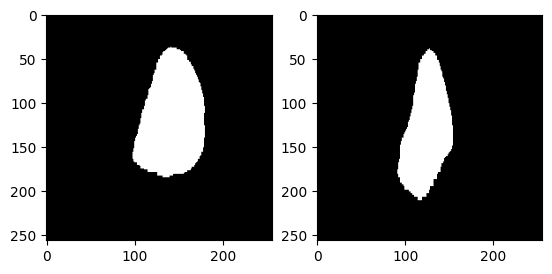

In [29]:
#close gaps in mask

kernel = np.ones((5,5),np.uint8)
mask1closed = cv2.morphologyEx(mask1, cv2.MORPH_CLOSE, kernel)
mask2closed = cv2.morphologyEx(mask2, cv2.MORPH_CLOSE, kernel)

plt.subplot(1, 2, 1)
plt.imshow(mask1closed, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(mask2closed, cmap="gray")
plt.show()

In [31]:
print(f"EF: {calculate_ejection_fraction(mask1closed, mask2closed)*100}")


EF: 48.08135140671467
